In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from IPython.display import display

import matplotlib.pylab as pylab

params = {'axes.titlesize': 10,
          'font.size': 12}
pylab.rcParams.update(params)

In [3]:
def extract_cols(df):
    df['seed'] = df['data'].apply(lambda x: int(x.split('/')[1].split('.')[0].split('_')[-1]))
    return df

def best_all(df, params, metric):
    df['hyper_id'] = df.groupby(params, dropna=False).ngroup()
    gr = df.groupby(['hyper_id'])[metric].agg(['mean', 'sem']).reset_index()

    hyper_id_sel = gr.loc[gr['mean'].idxmin(), 'hyper_id']
    df['hyper_id_sel'] = hyper_id_sel

    df2 = df.loc[df['hyper_id'] == df['hyper_id_sel']]

    return df2[['id', metric]]

def best_h(df, metric):
    return extract_cols(df).groupby(['id', 'seed'], as_index=False).apply(lambda x: x.loc[x[metric].idxmin()])

def worst_h(df, metric):
    return extract_cols(df).groupby(['id', 'seed'], as_index=False).apply(lambda x: x.loc[x[metric].idxmax()])

### SHD

In [3]:
metric = 'SHD_pattern'

with open('../config/algos_repo.json', 'r') as f:
    config = json.load(f)

algs = []

obj = config['resources']['structure_learning_algorithms']
for alg in obj:
    try:
        df = pd.read_csv(f'./results/syntren/{alg}.csv')
    except:
        continue

    print(alg)
    params = list(obj[alg][0].keys())

    df_def = best_all(df, params, metric)
    algs.append(df_def)
    
df_defs = pd.concat(algs, axis=0)

bench_all = pd.read_csv('./results/syntren/joint_benchmarks.csv', index_col=0)
bench_all['id'] = bench_all.apply(lambda x: x['id'].upper(), axis=1)

df_best = best_h(bench_all, metric)
df_worst = worst_h(bench_all, metric)

df_best['quality'] = 'best'
df_worst['quality'] = 'worst'
df_defs['quality'] = 'default'

pcalg_pc
tetrad_fges
tetrad_fci
gcastle_ica_lingam
gcastle_anm
cdt_cam
gcastle_notears
gcastle_notears_nonlinear


### Prepare All

In [4]:
bench_all = pd.read_csv('./results/syntren/joint_benchmarks.csv', index_col=0)
bench_all['id'] = bench_all.apply(lambda x: x['id'].upper(), axis=1)

metric = 'SHD_pattern'
df_best_shd = best_h(bench_all, metric)
df_worst_shd = worst_h(bench_all, metric)

df_best_shd['quality'] = 'best'
df_worst_shd['quality'] = 'worst'


metric = 'FP_skel'
df_best_fp = best_h(bench_all, metric)
df_worst_fp = worst_h(bench_all, metric)

df_best_fp['quality'] = 'best'
df_worst_fp['quality'] = 'worst'


metric = 'FN_skel'
df_best_fn = best_h(bench_all, metric)
df_worst_fn = worst_h(bench_all, metric)

df_best_fn['quality'] = 'best'
df_worst_fn['quality'] = 'worst'

## Plots

In [5]:
df_final = pd.concat([df_best, df_defs, df_worst], axis=0)
df_final['id'] = df_final.apply(lambda x: x['id'].upper(), axis=1)

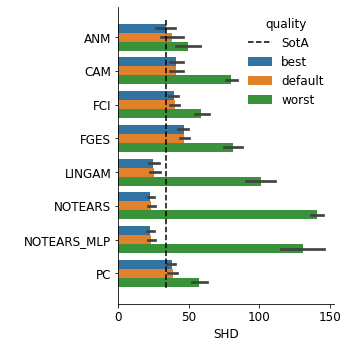

In [6]:
sns.catplot(data=df_final, x='SHD_pattern', y='id', hue='quality', kind='bar', orient='h', legend=None).set(ylabel=' ', xlabel='SHD')

plt.vlines(33.7, ymin=-0.5, ymax=7.5, linestyles='dashed', label='SotA', colors='k')
plt.legend(loc='upper right', frameon=False, title='quality')

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_quality.pdf', dpi=1000)

## Hard defaults

In [5]:
df_paper_defs = extract_cols(pd.read_csv('./results/syntren_defaults/joint_benchmarks.csv', index_col=0))
df_paper_defs['quality'] = 'default'

defs = []

# from ./results/defaults/
defs.append(bench_all.loc[(bench_all['id'] == 'ANM') & (bench_all['alpha'] == 0.001)])
defs.append(bench_all.loc[(bench_all['id'] == 'CAM') & (bench_all['cutoff'] == 0.001)])
defs.append(bench_all.loc[(bench_all['id'] == 'FCI') & (bench_all['alpha'] == 0.001)])
defs.append(bench_all.loc[(bench_all['id'] == 'FGES') & (bench_all['penaltyDiscount'] == 1.5)])
defs.append(bench_all.loc[(bench_all['id'] == 'LINGAM') & (bench_all['thresh'] == 0.5) & (bench_all['max_iter'] == 100)])
defs.append(bench_all.loc[(bench_all['id'] == 'NOTEARS_MLP') & (bench_all['lambda1'] == 0.01) & (bench_all['lambda2'] == 0.1) & (bench_all['w_threshold'] == 0.5) & (bench_all['hidden_units'] == 16)])
defs.append(bench_all.loc[(bench_all['id'] == 'NOTEARS') & (bench_all['lambda1'] == 0.2) & (bench_all['w_threshold'] == 0.2) & (bench_all['max_iter'] == 100)])
defs.append(bench_all.loc[(bench_all['id'] == 'PC') & (bench_all['alpha'] == 0.002)])

df_hard_defs = pd.concat(defs, axis=0)
df_hard_defs['quality'] = 'sim_mean'

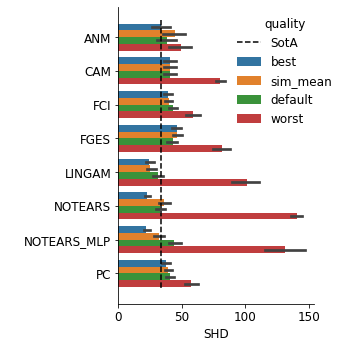

In [15]:
df_final2 = pd.concat([df_best, df_hard_defs, df_paper_defs, df_worst], axis=0)
df_final2['id'] = df_final2.apply(lambda x: x['id'].upper(), axis=1)

sns.catplot(data=df_final2, x='SHD_pattern', y='id', hue='quality', kind='bar', orient='h', legend=None).set(ylabel=' ', xlabel='SHD')

plt.vlines(33.7, ymin=-0.5, ymax=7.5, linestyles='dashed', label='SotA', colors='k')
plt.legend(loc='upper right', frameon=False, title='quality', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_quality_hard.pdf', dpi=1000)

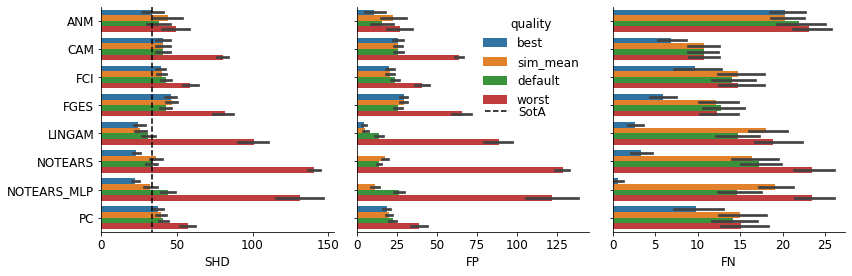

In [11]:
df_final_shd = pd.concat([df_best_shd, df_hard_defs, df_paper_defs, df_worst_shd], axis=0)
df_final_shd['id'] = df_final_shd.apply(lambda x: x['id'].upper(), axis=1)

df_final_fp = pd.concat([df_best_fp, df_hard_defs, df_paper_defs, df_worst_fp], axis=0)
df_final_fp['id'] = df_final_fp.apply(lambda x: x['id'].upper(), axis=1)

df_final_fn = pd.concat([df_best_fn, df_hard_defs, df_paper_defs, df_worst_fn], axis=0)
df_final_fn['id'] = df_final_fn.apply(lambda x: x['id'].upper(), axis=1)

fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(12, 4))
axs = axs.flatten()

ax = axs[0]
sns.barplot(data=df_final_shd, y='id', x='SHD_pattern', hue='quality', orient='h', ax=ax)
sota = ax.vlines(33.7, ymin=-0.5, ymax=7.5, linestyles='dashed', label='SotA', colors='k')
ax.set_ylabel('')
ax.set_xlabel('SHD')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

ax = axs[1]
sns.barplot(data=df_final_fp, y='id', x='FP_skel', hue='quality', orient='h', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('FP')
ax.spines[['right', 'top']].set_visible(False)
#ax.get_legend().remove()
ax.get_legend().get_frame().set_alpha(0)

ax = axs[2]
sns.barplot(data=df_final_fn, y='id', x='FN_skel', hue='quality', orient='h', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('FN')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

fig.legend(loc='lower center', frameon=False, handles=[sota], bbox_to_anchor=(0.603, 0.53))

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_quality_all.pdf', dpi=1000)

## Tables

In [31]:
df_best['best'] = df_best.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_best.drop(columns=['sem'], inplace=True)

df_defs['default'] = df_defs.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_defs.drop(columns=['sem'], inplace=True)

df_worst['worst'] = df_worst.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_worst.drop(columns=['sem'], inplace=True)

merge_key = ['id']
df_final = df_best.merge(df_defs, on=merge_key).merge(df_worst, on=merge_key)

df_final['id'] = df_final.apply(lambda x: x['id'].upper(), axis=1)
df_final.set_index('id', inplace=True)

In [32]:
df_final[['best', 'default', 'worst']]

,best,default,worst
id,,,
ANM,33.5 (3.79),38.3 (4.09),49.2 (4.64)
CAM,40.9 (2.49),41.0 (2.47),80.2 (2.11)
FCI,39.3 (1.69),39.9 (1.63),58.9 (2.83)
FGES,46.4 (1.93),46.5 (1.85),81.6 (3.52)
LINGAM,24.5 (1.96),25.1 (1.97),101.2 (5.52)
NOTEARS,22.8 (1.33),23.5 (1.32),140.8 (2.17)
NOTEARS_MLP,22.1 (1.40),23.4 (1.30),131.2 (8.37)
PC,37.8 (1.55),38.4 (1.72),57.3 (2.74)


## Distributions

In [12]:
df = pd.read_csv('./results/syntren/joint_benchmarks.csv', index_col=0)
df['id'] = df.apply(lambda x: x['id'].upper(), axis=1)
algs = df['id'].unique()
algs.sort()

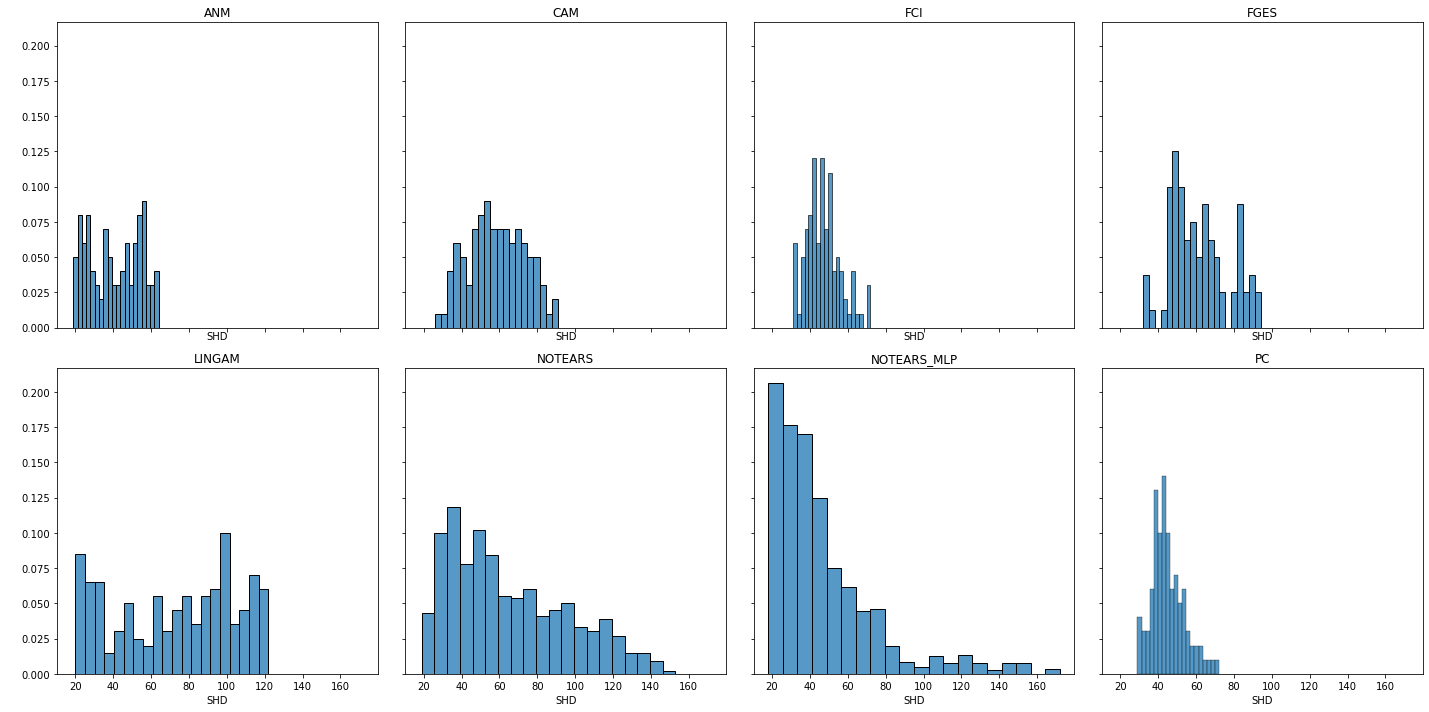

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()
for ax, alg in zip(axes, algs):
    ax.set_title(alg)
    ax.set_xlabel('SHD')
    ax.set_ylabel(' ')
    sns.histplot(df.loc[df['id'] == alg, 'SHD_pattern'], ax=ax, stat='probability', bins=20)

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_h_dist.pdf', dpi=1000)

<AxesSubplot:xlabel='SHD_pattern', ylabel='id'>

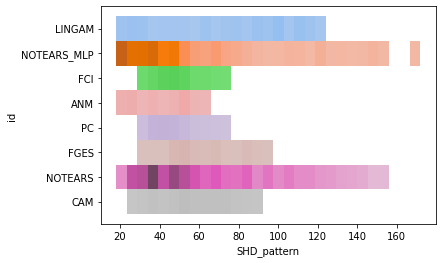

In [21]:
sns.histplot(df, x='SHD_pattern', y='id', hue='id', legend=False)

<AxesSubplot:xlabel='SHD_pattern', ylabel='id'>

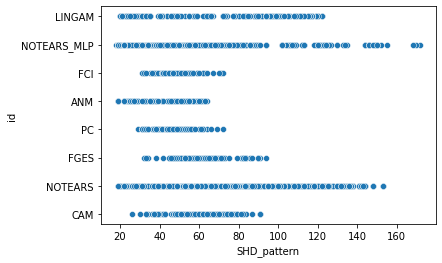

In [22]:
sns.scatterplot(data=df, x='SHD_pattern', y='id')

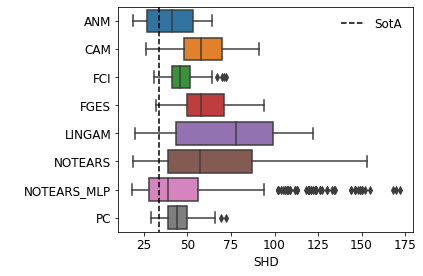

In [13]:
sns.boxplot(data=df, x='SHD_pattern', y='id', order=algs).set(xlabel='SHD', ylabel=' ')

plt.vlines(33.7, ymin=-0.5, ymax=7.5, linestyles='dashed', label='SotA', colors='k')
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_h_box.pdf', dpi=1000)

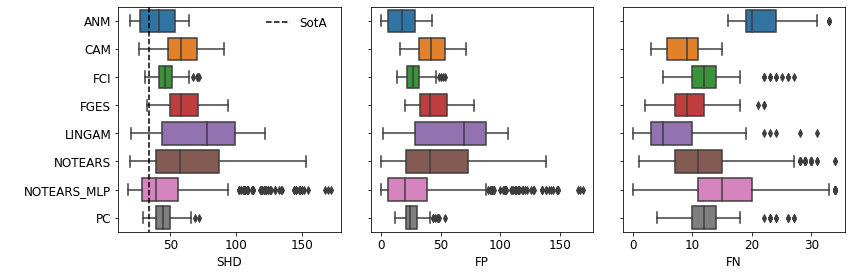

In [23]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(12, 4))
axs = axs.flatten()

ax = axs[0]
sns.boxplot(data=df, x='SHD_pattern', y='id', order=algs, ax=ax).set(xlabel='SHD', ylabel=' ')
sota = ax.vlines(33.7, ymin=-0.5, ymax=7.5, linestyles='dashed', label='SotA', colors='k')

ax = axs[1]
sns.boxplot(data=df, x='FP_skel', y='id', order=algs, ax=ax).set(xlabel='FP', ylabel=' ')

ax = axs[2]
sns.boxplot(data=df, x='FN_skel', y='id', order=algs, ax=ax).set(xlabel='FN', ylabel=' ')


fig.legend(loc='lower center', frameon=False, handles=[sota], bbox_to_anchor=(0.35, 0.84))

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_h_box_all.pdf', dpi=1000)

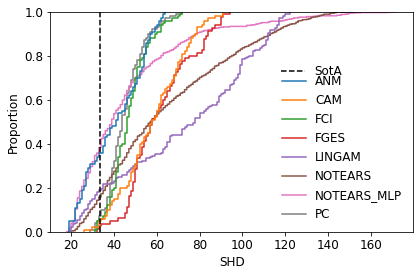

In [27]:
fig, ax = plt.subplots()

g = sns.ecdfplot(data=df, x='SHD_pattern', hue='id', hue_order=algs, legend=True, ax=ax)
g.set(xlabel='SHD')
    
sota = plt.vlines(33.7, ymin=0, ymax=1, linestyles='dashed', label='SotA', colors='k')

ax.get_legend().set_title('')
ax.get_legend().get_frame().set_alpha(0)

fig.legend(loc='lower center', frameon=False, handles=[sota], bbox_to_anchor=(0.735, 0.67))

plt.tight_layout()
plt.savefig('./plots/syntren/syntren_h_ecdf.pdf', dpi=1000)